# Evaluation Deblurring

(GitHub for data)[https://github.com/jiamings/ddrm-exp-datasets]



In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install --upgrade {"git+https://github.com/pesser/pytorch_diffusion.git"}
from pytorch_diffusion.diffusion import get_beta_schedule, Diffusion
!pip install
!pip install torchmetrics[image]
!pip install pytorch-ignite
!pip install tqdm

from IPython.display import clear_output
clear_output()

In [ ]:
import os
from google.colab import drive

drive_check = os.path.ismount('/content/drive/')
# check if already mounted
if not drive_check:
		drive.mount('/content/drive/')

%cd ./drive/MyDrive/DDRM_2

Mounted at /content/drive/
/content/drive/MyDrive/DDRM_2


In [ ]:
import random

# Torch imports
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from ignite.metrics import PSNR, SSIM
from ignite.engine import *
from torchmetrics.image.kid import KernelInceptionDistance

# Import diffusion model
from pytorch_diffusion.diffusion import get_beta_schedule, Diffusion

# imports for plotting
import PIL
from skimage import io
import matplotlib.pyplot as plt
from IPython.display import Image

# For progess bar
from tqdm import tqdm

# Costum imports
from utils.degradation import Degradation, UniformBlur, Noising
from utils.data_utils import plot_batches, set_device, eval_step
from utils.ddrm import DDRM


# Testing if import worked correctly
device = set_device()


Using device: cuda


In [ ]:
# Initialise Hyperparameters
batch_size = 4
kernel_size=(9,9)
image_size=(256,256)

eta = 0.85
eta_b = 1
n_steps = 20
time_steps=1000

std = 0.1
debug_mode = False

In [ ]:
# Define metrics for evaluation of model performance
default_evaluator = Engine(eval_step)

# PSNR Score
psnr = PSNR(data_range=1, device='cpu')
psnr.attach(default_evaluator, 'psnr')

# SSIM Score
ssim = SSIM(data_range=1, kernel_size=kernel_size)
ssim.attach(default_evaluator, 'ssim')

## Noiseless Deblurring

In [ ]:
degradation_model = UniformBlur(device=device, std=std)

In [ ]:
data_dir = './data/church_outdoor_val_images/'

data = ImageFolder(
    root=data_dir,
    transform=transforms.Compose([
        transforms.PILToTensor(),
        transforms.Resize(image_size),
        ])
)

data_loader = DataLoader(
    data,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True
)

print(f'Length of Dataset: {data.__len__()}')
print(f'Length of DataLoader: {data_loader.__len__()}')

Length of Dataset: 300
Length of DataLoader: 75


In [ ]:
name = "lsun_bedroom"
# name = "lsun_church"
# name = "image_net"

diffusion = DDRM.from_pretrained(name, device=device, num_timesteps=time_steps)
hyperparams = dict(sigma_y = std, eta = eta, eta_b =  eta_b, n_steps = n_steps)


Instantiating


455MB [00:44, 10.2MB/s]                           


Loading checkpoint /root/.cache/diffusion_models_converted/diffusion_lsun_bedroom_model/model-2388000.ckpt
Moved model to cuda


In [ ]:
# Run evaluation of model

# Save batches for plots
save_every_steps = 0
sample_batches_for_plots_noiseless = []


# Lists for storing scores of baseline
psnr_baseline, ssim_baseline = [], []

# Lists for storing scores of DDRM
psnr_ddrm, ssim_ddrm = [], []

for i, batch in enumerate(tqdm(data_loader)):
  batch = (batch[0]/255).to(device)

  if batch.shape[0] != batch_size:
    continue

  # Degrade the sample
  degraded_batch = degradation_model(batch)


  # Denoise and deblurr the sample
  reconstructed, steps = diffusion.denoise(batch_size,
                              degraded_batch,
                              n_steps=n_steps,
                              degradation_model = degradation_model,
                              hyperparams=hyperparams)


  y = batch.cpu()
  y_degraded = degraded_batch.cpu()
  y_pred = reconstructed.cpu()

  # Compute PSNR and SSID, then append to score lists
  state_baseline = default_evaluator.run([[y, y_degraded]])
  psnr_baseline.append(state_baseline.metrics['psnr'])
  ssim_baseline.append(state_baseline.metrics['ssim'])

  state_ddrm = default_evaluator.run([[y_pred, y]])
  psnr_ddrm.append(state_ddrm.metrics['psnr'])
  ssim_ddrm.append(state_ddrm.metrics['ssim'])

  # Save batches save_every_steps steps
  if save_every_steps==0:
    sample_batches_for_plots_noiseless.append([batch, degraded_batch, reconstructed])
  elif (i%save_every_steps)==0:
    sample_batches_for_plots_noiseless.append([batch, degraded_batch, reconstructed])


  if debug_mode:
    # plot and break for debugging
    plot_batches([batch, degraded_batch, reconstructed])
    break


print('-------------------| Baseline |-------------------')
print(f'# Samples: {len(psnr_baseline)*batch_size}')
print(f'Mean PSNR: {sum(psnr_baseline)/len(psnr_baseline)}')
print(f'Mean SSIM: {sum(ssim_baseline)/len(ssim_baseline)}')

print('---------------------| DDRM |---------------------')
print(f'Mean PSNR: {sum(psnr_ddrm)/len(psnr_ddrm)}')
print(f'Mean SSIM: {sum(ssim_ddrm)/len(ssim_ddrm)}')

  0%|          | 0/75 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pytorch_diffusion/diffusion.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torc

-------------------| Baseline |-------------------
# Samples: 300
Mean PSNR: 16.847025822540566
Mean SSIM: 0.12596269803861332
---------------------| DDRM |---------------------
Mean PSNR: 22.74438247429172
Mean SSIM: 0.6327659867461382


In [ ]:
print(f'# of saved batches: {len(sample_batches_for_plots_noiseless)}')

# of saved batches: 75


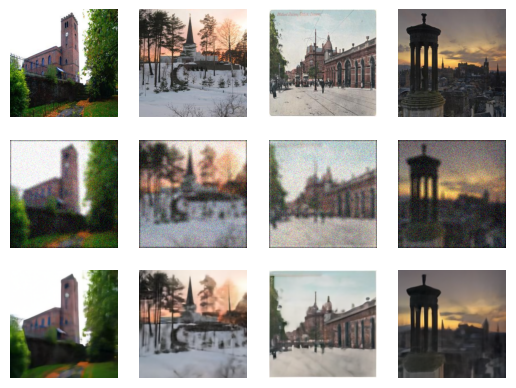

In [ ]:
plot_batches(sample_batches_for_plots_noiseless[1])


In [1]:
plot_batches(sample_batches_for_plots_noiseless[1][2])

NameError: ignored